In [1]:
import pandas as pd
df_wrime = pd.read_table('./wrime-ver1.tsv')
df_wrime.columns

Index(['Sentence', 'UserID', 'Datetime', 'Train/Dev/Test', 'Writer_Joy',
       'Writer_Sadness', 'Writer_Anticipation', 'Writer_Surprise',
       'Writer_Anger', 'Writer_Fear', 'Writer_Disgust', 'Writer_Trust',
       'Reader1_Joy', 'Reader1_Sadness', 'Reader1_Anticipation',
       'Reader1_Surprise', 'Reader1_Anger', 'Reader1_Fear', 'Reader1_Disgust',
       'Reader1_Trust', 'Reader2_Joy', 'Reader2_Sadness',
       'Reader2_Anticipation', 'Reader2_Surprise', 'Reader2_Anger',
       'Reader2_Fear', 'Reader2_Disgust', 'Reader2_Trust', 'Reader3_Joy',
       'Reader3_Sadness', 'Reader3_Anticipation', 'Reader3_Surprise',
       'Reader3_Anger', 'Reader3_Fear', 'Reader3_Disgust', 'Reader3_Trust',
       'Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anticipation',
       'Avg. Readers_Surprise', 'Avg. Readers_Anger', 'Avg. Readers_Fear',
       'Avg. Readers_Disgust', 'Avg. Readers_Trust'],
      dtype='object')

In [2]:
emotions = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotions], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
"""
df_wrime.groupby(['Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anticipation',
       'Avg. Readers_Surprise', 'Avg. Readers_Anger', 'Avg. Readers_Fear',
       'Avg. Readers_Disgust', 'Avg. Readers_Trust']).size().plot(kind='bar')
"""
df_wrime = df_wrime[is_target]
df_wrime_target = df_wrime[['Sentence', 'readers_emotion_intensities', 'Train/Dev/Test']]
df_wrime_target.head()

,Sentence,readers_emotion_intensities,Train/Dev/Test
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,"[0, 2, 0, 0, 0, 0, 0, 0]",train
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,"[1, 0, 0, 2, 0, 0, 0, 0]",train
6,やばい｡おもろいな?思ってみてみた「シャレードがいっぱい」｡よすぎるやん。,"[2, 0, 0, 0, 0, 0, 0, 0]",train
7,おなかすいた…夜ご飯仲間募集｡,"[0, 0, 2, 0, 0, 0, 0, 0]",train
9,最近アップにしていたので気づかなかったけど、ちゃんとブローしたらモテキ小宮山夏樹(後期)に似...,"[1, 0, 2, 0, 0, 0, 0, 0]",train


In [3]:
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('test')])

print('train: ', len(df_train))
print('test: ', len(df_test))

train:  17104
test:  720


In [4]:
import torch
print(torch.cuda.is_available())
x = torch.rand(5,3)
print(x)

True
tensor([[0.1328, 0.3178, 0.5760],
        [0.7766, 0.5770, 0.4023],
        [0.7457, 0.1531, 0.6228],
        [0.3067, 0.8738, 0.1249],
        [0.3778, 0.8704, 0.7670]])


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = "cuda:0"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=8)
model = model.to(device)


/home/sarashin/.local/share/virtualenvs/wrime-fd-hj1sF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expecte

In [6]:
from datasets import Dataset
import numpy as np

target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_train[target_columns])

def tokenize_function(batch):
    """Tokenizerを適用 （感情強度の正規化も同時に実施する）."""
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

In [7]:
from transformers import TrainingArguments, Trainer
import evaluate

# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

# 訓練時の設定
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()

/home/sarashin/.local/share/virtualenvs/wrime-fd-hj1sF/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                                  
  9%|▉         | 200/2138 [05:34<11:46,  2.75it/s] 

{'eval_loss': 0.2832302153110504, 'eval_accuracy': 0.5470650140318054, 'eval_runtime': 261.4463, 'eval_samples_per_second': 65.421, 'eval_steps_per_second': 8.178, 'epoch': 0.09}


                                                     
 19%|█▊        | 400/2138 [11:08<10:31,  2.75it/s] 

{'eval_loss': 0.26060956716537476, 'eval_accuracy': 0.6219597754911131, 'eval_runtime': 261.222, 'eval_samples_per_second': 65.477, 'eval_steps_per_second': 8.185, 'epoch': 0.19}


 23%|██▎       | 500/2138 [11:44<09:55,  2.75it/s]   

{'loss': 0.2957, 'learning_rate': 3.8306828811973814e-05, 'epoch': 0.23}


                                                  
 28%|██▊       | 600/2138 [16:37<09:20,  2.75it/s] 

{'eval_loss': 0.25242412090301514, 'eval_accuracy': 0.6315481758652947, 'eval_runtime': 254.8108, 'eval_samples_per_second': 67.124, 'eval_steps_per_second': 8.391, 'epoch': 0.28}


                                                     
 37%|███▋      | 800/2138 [22:00<07:45,  2.87it/s] 

{'eval_loss': 0.2443469613790512, 'eval_accuracy': 0.6664522918615529, 'eval_runtime': 252.7188, 'eval_samples_per_second': 67.68, 'eval_steps_per_second': 8.46, 'epoch': 0.37}


 47%|████▋     | 1000/2138 [23:13<06:53,  2.75it/s]  

{'loss': 0.2625, 'learning_rate': 2.6613657623947615e-05, 'epoch': 0.47}


                                                   
 47%|████▋     | 1000/2138 [27:34<06:53,  2.75it/s]

{'eval_loss': 0.23596523702144623, 'eval_accuracy': 0.677677736202058, 'eval_runtime': 261.4195, 'eval_samples_per_second': 65.427, 'eval_steps_per_second': 8.178, 'epoch': 0.47}


                                                      
 56%|█████▌    | 1200/2138 [33:04<05:41,  2.75it/s]

{'eval_loss': 0.22709457576274872, 'eval_accuracy': 0.7060336763330215, 'eval_runtime': 255.4288, 'eval_samples_per_second': 66.962, 'eval_steps_per_second': 8.37, 'epoch': 0.56}


                                                      
 65%|██████▌   | 1400/2138 [38:23<04:15,  2.89it/s]

{'eval_loss': 0.22253134846687317, 'eval_accuracy': 0.7329279700654817, 'eval_runtime': 249.6084, 'eval_samples_per_second': 68.523, 'eval_steps_per_second': 8.565, 'epoch': 0.65}


 70%|███████   | 1500/2138 [38:58<03:42,  2.86it/s]   

{'loss': 0.2489, 'learning_rate': 1.492048643592142e-05, 'epoch': 0.7}


                                                   
 75%|███████▍  | 1600/2138 [43:58<03:06,  2.88it/s]

{'eval_loss': 0.2181844413280487, 'eval_accuracy': 0.7369036482694107, 'eval_runtime': 264.5705, 'eval_samples_per_second': 64.648, 'eval_steps_per_second': 8.081, 'epoch': 0.75}


                                                      
 84%|████████▍ | 1800/2138 [49:42<02:05,  2.68it/s]

{'eval_loss': 0.21252626180648804, 'eval_accuracy': 0.7572497661365762, 'eval_runtime': 269.4719, 'eval_samples_per_second': 63.472, 'eval_steps_per_second': 7.934, 'epoch': 0.84}


 94%|█████████▎| 2000/2138 [50:57<00:51,  2.69it/s]  

{'loss': 0.2397, 'learning_rate': 3.2273152478952295e-06, 'epoch': 0.94}


                                                   
 94%|█████████▎| 2000/2138 [55:25<00:51,  2.69it/s]

{'eval_loss': 0.2095615118741989, 'eval_accuracy': 0.7585360149672591, 'eval_runtime': 267.8084, 'eval_samples_per_second': 63.867, 'eval_steps_per_second': 7.983, 'epoch': 0.94}


100%|██████████| 2138/2138 [56:17<00:00,  1.58s/it]  

{'train_runtime': 3377.0459, 'train_samples_per_second': 5.065, 'train_steps_per_second': 0.633, 'train_loss': 0.260342506073255, 'epoch': 1.0}


TrainOutput(global_step=2138, training_loss=0.260342506073255, metrics={'train_runtime': 3377.0459, 'train_samples_per_second': 5.065, 'train_steps_per_second': 0.633, 'train_loss': 0.260342506073255, 'epoch': 1.0})

<Figure size 500x100 with 0 Axes>

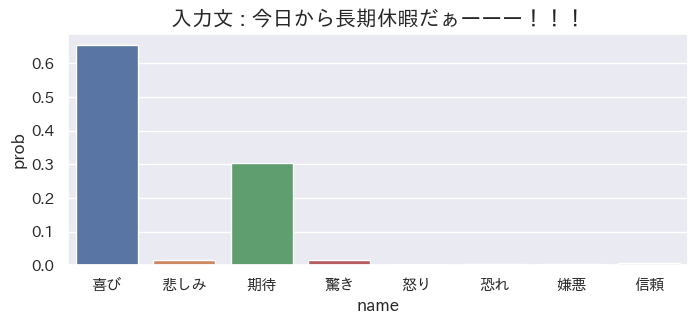

In [14]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# 動作確認
plt.figure(figsize=(5,1))

emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼'] 

# ソフトマックス関数
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)
    else:
        print(out_dict)

analyze_emotion('今日から長期休暇だぁーーー！！！', True)

In [15]:
model_path = 'epoch_1.pth'
torch.save(model.state_dict(), model_path)